In [1]:
from random import randint
from tqdm import tqdm
import re
import torch
import torch.nn as nn
import numpy as np
from nltk import tokenize
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader

Скачиваем датасет, который будем использовать для вставки в текст слов паразитов

In [3]:
from datasets import load_dataset
dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

Dataset gazeta_dataset downloaded and prepared to /root/.cache/huggingface/datasets/IlyaGusev___gazeta_dataset/default/1.0.0/ef9349c3c0f3112ca4036520d76c4bc1b8a79d30bc29643c6cae5a094d44e457. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
len(dataset['train']['text'])

52400

In [5]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', padding=True)
model = BertModel.from_pretrained("bert-base-multilingual-cased")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# text = "два"
# encoded_input = tokenizer(text, return_tensors='pt', padding='max_length', max_length=512)
# output = model(**encoded_input)

In [13]:
# encoded_input

## Просмотр для слов токенов слов

In [266]:
# "типа" -> 21798
# "короче" -> 80062
cur_bad_word = "короче"
cur_bad_word_id = 80062
input_ids = tokenizer.encode(cur_bad_word)
input_ids

[101, 80062, 67741, 102]

In [267]:
output = tokenizer.decode(input_ids)
output = tokenizer.decode([cur_bad_word_id])
output

'кор'

### END токены слов

In [53]:
# !cd ../input/sent-with-bad-words && ls

In [268]:
# cnt = 0
# sents = {}
# bad_words = ['короче', 'типа', 'как бы', 'это самое', 'таки', 'вот', 'ну', 'значит']
# for bad_word in bad_words:
#     sents[bad_word] = []
    
# for sent in tqdm(dataset['train']['text']):
#     words_in_sent = re.split('\W+', sent)
#     for bad_word in bad_words:
#         if bad_word in words_in_sent:
#             cnt += 1
#             sents[bad_word].append(sent)

In [269]:
# for bad_word in bad_words:
#     print(bad_word, len(sents[bad_word]))

### Create list with sentences contain word 'короче' as significant part of sentence

In [270]:
native_using = []

### For word 'короче'

In [271]:
native_using = []
with open("../input/sent-with-bad-words/sent_with_bad_word.txt", 'r') as file:
    for line in file:
        line = line.strip()
        native_using.append(line)

### For word 'типа'

In [26]:
native_using = []
with open("../input/small-tipa/sents_with_bad_word_tipa.txt", 'r') as file:
    for line in file:
        line = line.strip()
        native_using.append(line)

In [272]:
len(native_using)

6598

In [273]:
clear_sents = []

In [274]:
for text in dataset['train']['text']:
    if len(clear_sents) > len(native_using):
        break
    sents = tokenize.sent_tokenize(text)
    clear_sents += sents

In [275]:
len(clear_sents)

6600

In [276]:
class ParasiteWordsClfHead(nn.Module):
    def __init__(self, in_size, out_size):
        super(ParasiteWordsClfHead, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [277]:
def insert_word(word: str, text: str) -> str:
    text_list = text.split(' ')
    pos = randint(0, len(text_list))
    text_list.insert(pos, word)
    result_string = " ".join(text_list)
    return result_string

In [278]:
def calc_labels(true_ids: torch.tensor, 
                inp_ids: torch.tensor, 
                mask_ids: set = {23279, 20413}) -> np.array:
    counter = 0
    indices = []
#     print(true_ids)
#     print(inp_ids)
    for i, x in enumerate(inp_ids):
        if x == true_ids[i - counter]:
            continue
        elif int(x) in mask_ids:
            counter += 1
            indices.append(i)
        else:
            print("DEBUG", i, counter, x, true_ids[i - counter], inp_ids[i - 10:i + 10], true_ids[i - 10:i + 10])
            print("DEBUG", true_ids.shape, inp_ids.shape)
            raise Exception("Bad token in calc_labels")
            
#     print(f"DEBUG: indices of bad_words: ", indices)
    
    labels = np.zeros(len(inp_ids), dtype=int)
    for ind in indices:
        labels[ind] = 1
    return labels

In [279]:
def test_single_sent(sentence: str):
#     token = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    bad_words = ['короче', 'типо', 'как бы', 'это самое', 'таки', 'вот', 'ну', 'значит']
    set_bad_words_tokens = set()
    for bad_word in bad_words:
        set_bad_words_tokens.update(set(tokenizer.encode(bad_word)[1:-1]))
        
    source_tokenized_sent = tokenizer.encode(sentence)
    inserted_sent = insert_word('как бы', sentence)
    
    insert_tokenized_sent = tokenizer.encode(inserted_sent)
#     print("TEST: source_tokenized_sent", source_tokenized_sent)
#     print("TEST: insert_tokenized_sent", insert_tokenized_sent)
    labels = calc_labels(source_tokenized_sent, insert_tokenized_sent, set_bad_words_tokens)
#     print("TEST: labels", labels)
    
    inds = np.where(labels == 1)[0]
    
    for ind in np.flip(inds):
        insert_tokenized_sent.pop(int(ind))
    
    assert(insert_tokenized_sent == source_tokenized_sent)
    

def test_calc_labels(sentenes: list):
    for sent in sentenes:
        test_single_sent(sent)
    return

In [281]:
test_single_sent("привет мир привет мир")

In [282]:
# for sent in tqdm(dataset['train']['text'][:100]):
#     test_single_sent(sent)

In [283]:
# tokenizer(native_using[0], truncation=True, return_tensors='pt', padding='max_length', max_length=600)['input_ids'].shape[1]

In [284]:
# vals['input_ids'].shape[1]

In [285]:
# native_using[0]

In [286]:
# tokenizer(native_using[0], truncation=True, return_tensors='pt', max_length=512)['input_ids'].shape[1]

Фильтруем от слишком длинных последовательностей

In [287]:
filtered = filter(lambda val: tokenizer(val, truncation=True, return_tensors='pt', max_length=512)['input_ids'].shape[1] < 500, native_using)

In [288]:
filtered_list = list(filtered)

In [289]:
len(filtered_list)

6546

In [291]:
import random

In [292]:
# p2 = 'привет мир'

In [293]:
# tokenizer(p, truncation=True, return_tensors='pt', max_length=512)

In [294]:
# 101, 10913, 41102,   102

In [295]:
class TextDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, clear_sents, native_sents):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        bad_words = ['короче', 'типа', 'как бы', 'это самое', 'таки', 'вот', 'ну', 'значит']
        self.set_bad_words_tokens = set()
        total_sents = []
        for bad_word in bad_words:
            self.set_bad_words_tokens.update(set(tokenizer.encode(bad_word)[1:-1]))
        
        self.sentences = []
        
        for sent in native_sents:
            self.sentences.append([1, sent])
            
        for sent in clear_sents:
            self.sentences.append([0, sent])
            
        random.shuffle(self.sentences)
#         self.sentences = sentences
        

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        
        
        if self.sentences[idx][0] == 1:
            tokenized_src_data = tokenizer(self.sentences[idx][1], truncation=True, return_tensors='pt', padding='max_length', max_length=512)
            labels = np.zeros(len(tokenized_src_data['input_ids'][0]), dtype=int)
            print("Debug NATIVE", self.sentences[idx][1])
            return (tokenized_src_data, labels)
        
        
        
#         self.sentences[idx] = self.sentences[idx][0:500]
        inserted_sentence = self.sentences[idx][1]
        
        for i in range(1):
            inserted_sentence = insert_word(cur_bad_word, inserted_sentence)
        
        print("Debug BAD", inserted_sentence)
        tokenized_src_data = tokenizer(self.sentences[idx][1], truncation=True, return_tensors='pt', padding='max_length', max_length=512)
        tokenized_ins_data = tokenizer(inserted_sentence, truncation=True, return_tensors='pt', padding='max_length', max_length=512)
#         print(self.sentences[idx], inserted_sentence, sep='\n\n\n\n')
        
        tokenized_src_sent = tokenized_src_data['input_ids'][0]
        tokenized_ins_sent = tokenized_ins_data['input_ids'][0]
        
        labels = calc_labels(tokenized_src_sent, 
                             tokenized_ins_sent,
                             self.set_bad_words_tokens)
        
#         print(model(**tokenized_ins_data))
        return (tokenized_ins_data, labels)

In [296]:
cur_bad_word

'короче'

In [297]:
len(clear_sents)

6600

In [298]:
len(filtered_list)

6546

In [299]:
# clear_sents

In [300]:
train_dataset = TextDataset(clear_sents, filtered_list)
test_dataset = TextDataset(clear_sents, filtered_list)

In [301]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [302]:
loss = torch.nn.L1Loss()
network = ParasiteWordsClfHead(768, 1)
optimizer = torch.optim.Adam(network.parameters(), lr=0.01) 

In [303]:
for X, y in train_loader:
    for key, value in X.items():
        X[key] = torch.squeeze(X[key], 1)
#     model(**X)
    break


Debug NATIVE Крылья короче, чем у "E. radiatus", а взрослая особь более пёстрая и без рыжеватого окраски нижней части тела.
Debug NATIVE Усики 11-члениковые (3-й сегмент короче первого).
Debug BAD — Могу короче говорить только о себе.
Debug BAD Фонд Pamplona Capital Management может приобрести обувную марку Dr Martens, сообщили Bloomberg и The Sunday короче Times.


In [304]:
MAX_LENGHT = 512

In [305]:
def _epoch(network_bert, network_head, 
           loss, loader,
           optimizer=None,
           device = 'cpu',
           backward=True,
           ):
    losses = []
    accuracies = []
    cnt = 10
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        y_one_dim = y.view(y.shape[0] * y.shape[1])
#         print("y_one_dim.shape", y_one_dim.shape)
#         print("y.shape", y.shape)
        for key, value in X.items():
            X[key] = torch.squeeze(X[key], 1)
#         data = torch.squeeze(X[key], 1)
        indexes_with_bad_words = []
        for i in range(X['input_ids'].shape[0]):
            indexes_with_bad_words.append(X['input_ids'][i].tolist().index(cur_bad_word_id) + MAX_LENGHT * i)
        print("indexes_with_bad_words", indexes_with_bad_words)
        
        y = y.view(-1)
        with torch.no_grad():
            model_output = network_bert(**X)
#         print("model_output[0].shape: ", model_output[0].shape)
#         print("model_output[0][0]: ", model_output[0][0])
        word_embeddings = model_output[0].view(model_output[0].shape[0] * model_output[0].shape[1], -1)
        filtered_embeddings = torch.index_select(word_embeddings, 0, torch.tensor(indexes_with_bad_words))
        filtered_y = torch.index_select(y_one_dim, 0, torch.tensor(indexes_with_bad_words))
#         print("filtered_embeddings.shape: ", filtered_embeddings.shape)
#         print("word_embeddings.shape: ", word_embeddings.shape)
        network_head.zero_grad()
        prediction = network_head(filtered_embeddings)
        print("prediction.shape after head", prediction.shape)#.squeeze()
        prediction = prediction.squeeze()
#         print("prediction", prediction)#.squeeze()
#         prediction = (prediction>0.5).float()
#         print("prediction", prediction)
#         print("prediction.dtype", prediction.dtype)
        filtered_y = filtered_y.float()
#         print("filtered_y.dtype", filtered_y.dtype)
        loss_batch = loss(prediction, filtered_y)
#         print("loss_batch", loss_batch)
        val = loss_batch.cpu().item()
        losses.append(val)
#         print(losses)
#         print("val", val)
        print("filtered_y", filtered_y)
        print("prediction", prediction)
        if backward:
            print("backward!!!")
            loss_batch.backward()
            optimizer.step()
#         prediction = prediction.max(0)[1]
#         print("filtered_y", filtered_y)
#         accuracies.append((prediction==filtered_y).cpu().float().numpy().mean())
        prediction = (prediction>0.5).float()
        accuracies.append((prediction==filtered_y).cpu().float().numpy().mean())
#         accuracies.append(val)
        cnt -= 1
        
        if cnt < 0:
            break
    return losses, accuracies

In [306]:
# _epoch(model, network, loss, train_loader, optimizer=optimizer)

In [307]:
model_output = ""

In [308]:
def train(network_bert, network_head, train_loader, test_loader,
          epochs, optimizer, loss, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
#     loss = nn.NLLLoss()
#     optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network_bert = network_bert.to(device)
    network_head = network_head.to(device)
    try:
        for epoch in range(epochs):
            network_head.train()
#             _epoch(model, network, loss, train_loader, optimizer=optimizer)
            losses, accuracies = _epoch(network_bert, 
                                        network_head,
                                        loss,
                                        train_loader,
                                        optimizer,
                                        device,
                                        True)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
#             network_head.eval()
#             losses, accuracies = _epoch(network_bert, 
#                                         network_head,
#                                         loss,
#                                         test_loader,
#                                         optimizer,
#                                         device,
#                                         False)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs


In [309]:
# network.parameters()

Epoch 9... (Train/Test) NLL: 0.055/0.055	Accuracy: 0.977/0.977


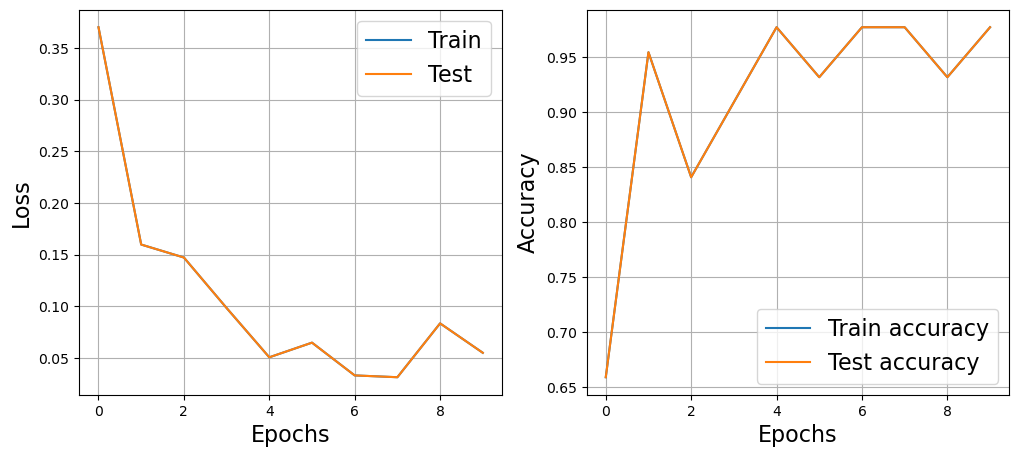

([0.36991840397769754,
  0.15978563420040617,
  0.1472469097617167,
  0.09844315814023669,
  0.0507677592236591,
  0.0649388697691558,
  0.0332570361206308,
  0.03150686602087014,
  0.08357667304914106,
  0.0551293415165591],
 [0.36991840397769754,
  0.15978563420040617,
  0.1472469097617167,
  0.09844315814023669,
  0.0507677592236591,
  0.0649388697691558,
  0.0332570361206308,
  0.03150686602087014,
  0.08357667304914106,
  0.0551293415165591],
 [0.65909094,
  0.95454544,
  0.84090906,
  0.90909094,
  0.97727275,
  0.9318182,
  0.97727275,
  0.97727275,
  0.9318182,
  0.97727275],
 [0.65909094,
  0.95454544,
  0.84090906,
  0.90909094,
  0.97727275,
  0.9318182,
  0.97727275,
  0.97727275,
  0.9318182,
  0.97727275])

In [310]:
train(model, network, train_loader, test_loader, 10, optimizer, loss)

In [311]:
# filtered_y tensor([0., 0., 0., 1.])
# # filtered_y tensor([1., 1., 1., 0.])

In [312]:
# for param in network.parameters():
#     print(param)

In [313]:
# old_param = []
# for param in network.parameters():
#     print(param)

In [314]:
# print(old_param)

In [315]:
# for name, param in network.named_parameters():
#     print(name, param)

In [316]:
!mkdir  models

mkdir: cannot create directory ‘models’: File exists


In [317]:
if cur_bad_word == 'короче':
    PATH_TO_MODEL = 'models/short_classif.pt'
elif cur_bad_word == 'типа':
    PATH_TO_MODEL = 'models/tipa_classif.pt'
else:
    PATH_TO_MODEL = 'models/classif.pt'

PATH_TO_MODEL

'models/short_classif.pt'

In [318]:
network

ParasiteWordsClfHead(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [319]:
torch.save(network.state_dict(), PATH_TO_MODEL)

In [320]:
network = ParasiteWordsClfHead(768, 1)
network.load_state_dict(torch.load(PATH_TO_MODEL))
# network.eval()

<All keys matched successfully>

In [321]:
network

ParasiteWordsClfHead(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

## Inference model

In [322]:
from transformers import BertTokenizer, BertModel

In [323]:
words_in_sent = re.split('\W+', sent)

In [394]:
class WordClassifier:
    def __init__(self, meta_info):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', padding=True)
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.bert.eval()
        self.context_independent_bad_words = ['ну']
        
        self.clf_heads = {}
        for bad_word, meta_data in meta_info.items():
            clf_head = ParasiteWordsClfHead(768, 1)
            clf_head.load_state_dict(torch.load(meta_data["model_path"]))
            self.clf_heads[bad_word] = {}
            self.clf_heads[bad_word]['model'] = clf_head
            self.clf_heads[bad_word]['id'] = meta_data['parasite_word_id']
            
        print(self.clf_heads)
#         self.bad_word_token_ids = [cur_bad_word_id,]
        
    
    def classify(self, sentence):
        words_in_sent = re.split('\W+', sentence)
        tokenized_sent = self.tokenizer(sentence, truncation=True, return_tensors='pt', padding='max_length', max_length=512)
        
        with torch.no_grad():
            model_output = self.bert(**tokenized_sent)
            word_embeddings = model_output[0].squeeze()
            
            predictions = {}
            counters = {}
            
            for bad_word, meta_data in self.clf_heads.items():
                indexes_with_parasite_ids = [index for (index, item) in enumerate(tokenized_sent['input_ids'][0].tolist()) if item == meta_data['id']]

                if len(indexes_with_parasite_ids) == 0:
                    continue
                filtered_embeddings = torch.index_select(word_embeddings, 0, torch.tensor(indexes_with_parasite_ids))
                predictions[bad_word] = meta_data['model'](filtered_embeddings)
                
                predictions[bad_word] = predictions[bad_word].squeeze(1)
                predictions[bad_word] = (predictions[bad_word]>0.5).float().tolist()
                
                counters[bad_word] = -1
                
    
            parasite_word_indexes = []
            
            
            for idx, word in enumerate(words_in_sent):
                if word in counters.keys():
                    counters[word] += 1
                    if predictions[word][counters[word]] >= 0.9:
                        parasite_word_indexes.append(idx)
            
                elif word in self.context_independent_bad_words:
                    parasite_word_indexes.append(idx)
                    
            return parasite_word_indexes
        

In [395]:
model_paths = {
    "короче": {
        "model_path": 'models/short_classif.pt',
        "parasite_word_id": 80062,
    },
    "типа": {
        "model_path": 'models/tipa_classif.pt',
        "parasite_word_id": 21798,
    }
}

In [396]:
# sent_text0 = "у нас получились довольно неплохие результаты"
# sent_text1 = "короче у нас получились довольно неплохие результаты"
# sent_text2 = "короче у нас получилось что первый короче чем второй"
# sent_text3 = "короче говоря получилось не очень"
# sent_text4 = "ну там короче было много денег"

In [408]:
test_cases_koroche = {
    "у нас получились довольно неплохие результаты": [],
    "ну короче у нас получились довольно неплохие результаты": [0, 1],
    "короче у нас получилось что первый короче чем второй": [0],
    "короче говоря ну получилось не очень": [0, 2],
    "ну там короче было много денег": [0, 2],
    "первый провод короче второго": [],
    "перерыва короче матча": [],
}

In [398]:
# sent_text0 = "у нас типа неплохо получилось"
# sent_text1 = "он полупроводникового типа"
# sent_text2 = "они довольно умные типа"
# sent_text3 = "формат бинарного типа"
# sent_text4 = "типа"

In [399]:
test_cases_tipa = {
    "ну у нас типа неплохо получилось": [0, 3],
    "он полупроводникового типа": [],
    "они довольно умные типа": [3],
    "формат бинарного типа": [],
    "ну типа": [0, 1]
}

In [411]:
test_cases_common = {
    "ну он короче шел по улице и типа понял что правая рука короче левой": [0, 2, 7],
    "карандаши квадратного типа короче круглого типа": [],
}

In [401]:
short_clf = WordClassifier(model_paths)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'короче': {'model': ParasiteWordsClfHead(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=1, bias=True)
    (1): Sigmoid()
  )
), 'id': 80062}, 'типа': {'model': ParasiteWordsClfHead(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=1, bias=True)
    (1): Sigmoid()
  )
), 'id': 21798}}


In [412]:
for test_case, labels in test_cases_tipa.items():
    predicts = short_clf.classify(test_case)
    if predicts != labels:
        print('BAD RESULT!', "Test: ", test_case, "labels:", labels, "predict:", predicts)
#     assert(predicts == labels)

In [413]:
test = "Короче, типа, я был на вечеринке у своего друга. Там было много народу, типа, и все они были очень веселыми. Мы пили пиво, короче, и слушали музыку. Типа, было так много людей, что я даже не помню всех их имен. Короче, мы провели там всю ночь, типа, и ушли только утром. Это была очень крутая вечеринка, типа, и я надеюсь, что еще раз попаду на нее. Короче, это был один из лучших вечеров в моей жизни, типа."

In [414]:
short_clf.classify(test)

[1, 13, 23, 46, 56, 76]

In [415]:
for test_case, labels in test_cases_koroche.items():
    predicts = short_clf.classify(test_case)
    if predicts != labels:
        print('BAD RESULT!', "Test: ", test_case, "labels:", labels, "predict:", predicts)
#         print()
#     assert(predicts == labels)

BAD RESULT! Test:  короче у нас получилось что первый короче чем второй labels: [0] predict: [0, 6]
BAD RESULT! Test:  первый провод короче второго labels: [] predict: [2]
BAD RESULT! Test:  перерыва короче матча labels: [] predict: [1]


In [416]:
for test_case, labels in test_cases_common.items():
    predicts = short_clf.classify(test_case)
    if predicts != labels:
        print('BAD RESULT!', "Test: ", test_case, "labels:", labels, "predict:", predicts)

BAD RESULT! Test:  карандаши квадратного типа короче круглого типа labels: [] predict: [3]


In [244]:
# cnt = 10
# for native_sent in native_using:
#     print(native_sent, short_clf.classify(native_sent))
#     cnt -= 1
#     if cnt < 0:
#         break

При такой системе приняты уроки длиной 45 минут (бывают короче, но, как правило, не менее 35 минут). [0.0]
Л. Никитин показал, что «Путь из варяг в греки» по Днепру практически не использовался до правления кагана Святослава, а древность этого пути была выдумана редактором «Повести временных лет» для обоснования посещения апостолом Андреем Русской земли в то время, когда он путешествовал из Константинополя в Рим по Дунаю по пути в 5—6 раз короче, чем путь по Днепру. [0.0]
С созданием водохранилищ тепловой режим Волги изменился: на верхних бьефах продолжительность ледовых явлений увеличилась, а на нижних стала короче.== Регионы на территории бассейна ==На начало XXI века в пределах бассейна Волги полностью или частично расположено 37 субъектов Российской Федерации. [0.0]
Похожие органические вещества с единичными С-С связями вымываются позже, чем подобные соединения с С=С связями или тройными С-С связями, так как двойные или тройные связи короче, чем одиночная С-С связь.Не зависимо от п